In [9]:
import numpy as np
import autograd.numpy as anp
from autograd import grad, jacobian
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *
from src.ODE_filters import *
from src.helpers import future_prediction
from src.plotting_utils import *
from tqdm import tqdm

### Plotting Specifications

In [10]:
from tueplots import axes
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})

In [11]:
plt.rcParams['figure.figsize']

[5.5, 3.399186938124422]

In [12]:
from tueplots import figsizes
figsize_config = figsizes.neurips2021(nrows=1, ncols=1)
##figsize_config['figure.figsize'][1] = 0.5
plt.rcParams.update(figsize_config)

In [13]:
plt.rcParams['figure.figsize']

[5.5, 3.399186938124422]

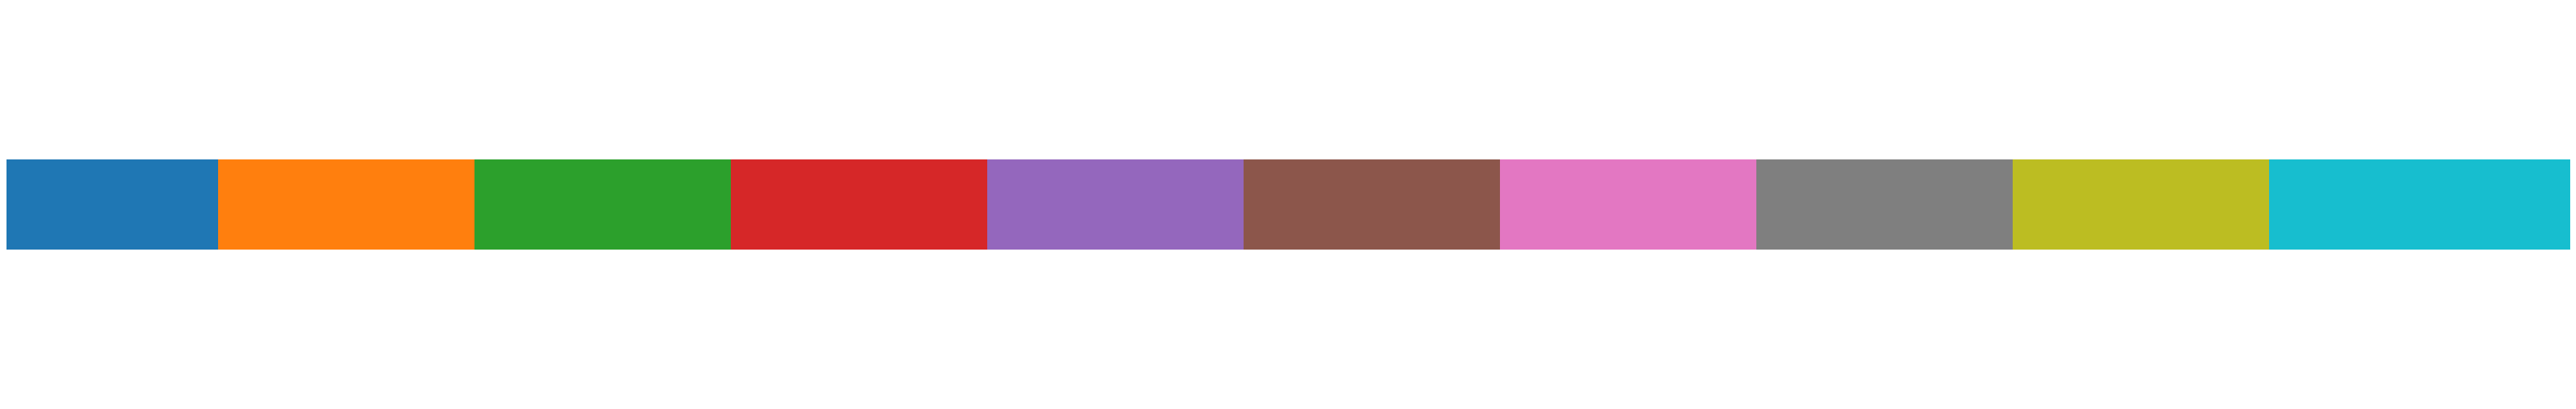

In [14]:
from cycler import cycler

# Get the color cycle from rcParams
color_cycler = plt.rcParams['axes.prop_cycle']
colors = color_cycler.by_key()['color']

# Visualize the colors
fig, ax = plt.subplots(figsize=(6, 1))
for i, color in enumerate(colors):
    ax.plot([i, i+1], [1, 1], color=color, linewidth=15)
ax.set_xlim(0, len(colors))
ax.set_ylim(0.5, 1.5)
ax.axis('off')
plt.show()

### ODE Problem Setup

In [61]:
#define the ODE x_dot = f(x)
def vf(x, beta=2, gamma=1., P=100):
    return anp.array([
        -beta*x[0]*x[1]/P,
        beta*x[0]*x[1]/P - gamma*x[1],
        gamma*x[1]
    ])

#define the initial value
y0 = anp.array([99., 1., 0.])

#set dimenisons
d, q = 3, 2

#Prior model for q=2 TODO: generalize this for variable q
A = lambda h: anp.array([[1.0, h, h**2/2.0], [0.0, 1.0, h], [0.0, 0.0, 1.0]])
sigma = 1.0
Q = lambda h: sigma**2 * anp.array([[h**5/20.0, h**4/8.0, h**3/6.0],
                                    [h**4/8.0, h**3/3.0, h**2/2.0],
                                    [h**3/6.0, h**2/2.0, h]])

# Taylor-mode init via autograd for q=2
Jvf = jacobian(vf)
x1 = vf(y0)
x2 = Jvf(y0) @ x1  # second derivative
mu_0 = anp.concatenate([y0, x1, x2])  # shape (d*(q+1),)
#mu_0 = np.concat([y0, vf(y0), np.zeros(d)])
Sigma_0 = anp.eye(d*(q+1)) * 0.0


# Discretization
t0, t1 = 0.0, 20.0
N = 60
ts = anp.linspace(t0, t1, num=N+1, endpoint=True)
h = (t1 - t0) / N

# Constant step consequences
A_h = anp.kron(A(h), anp.eye(d))
Q_h = anp.kron(Q(h), anp.eye(d))
b_h = anp.zeros((q+1)*d)
R_h = anp.eye(d)

#valid projections for q=2, TODO: generalize for variable q
E0 = anp.array([1.0, 0.0, 0.0])
E1 = anp.array([0.0, 1.0, 0.0])
E0 = anp.kron(E0, anp.eye(d))
E1 = anp.kron(E1, anp.eye(d))

# Measurement operator: x_dot - f(x) = 0
def g(X):
    x = anp.dot(E0, X)
    x_dot = anp.dot(E1, X)
    return x_dot - vf(x)

jacobian_g = jacobian(g)

# Data
z_sequence = anp.zeros((N, d))

### Compute and Plot filtering results

In [62]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [63]:
#m_sequence = np.asarray(m_sequence, dtype=float)
#P_sequence = np.asarray(P_sequence, dtype=float)
#m_predictions = np.asarray(m_predictions, dtype=float)
#P_predictions = np.asarray(P_predictions, dtype=float)

In [64]:
m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

In [65]:
N_exact = 1000
h_exact = (t1-t0)/N_exact
t = np.linspace(t0,t1, N_exact+1)
z_sequence2 = np.zeros((N_exact,d))
A_h2 = np.kron(A(h_exact), np.eye(d))
Q_h2 = np.kron(Q(h_exact), np.eye(d))
m_sequence2, P_sequence2, m_predictions2, P_predictions2 = compute_kalman_forward_stable(mu_0, Sigma_0, A_h2, b_h, Q_h2, R_h, g, jacobian_g, z_sequence2, N_exact)
m_sequence2 = np.asarray(m_sequence2, dtype=float)
P_sequence2 = np.asarray(P_sequence2, dtype=float)
m_predictions2 = np.asarray(m_predictions2, dtype=float)
P_predictions2 = np.asarray(P_predictions2, dtype=float)
#Consequences of constant step size

m_exact, _ = compute_kalman_backward(m_sequence2, P_sequence2, m_predictions2, P_predictions2, A_h2, N_exact)

In [66]:
zs = []
zf_var = []
for k in range(m_sequence.shape[0]):
    zs.append(g(m_sequence[k,:]))
    Jk = jacobian_g(m_sequence[k, :])
    zf_var.append(Jk @ P_sequence[k, :] @ Jk.T)

zs = np.asarray(zs, dtype=float)
zf_var = np.asarray(zf_var, dtype=float)

### Iterative Forward plotting

In [67]:
m_sequence.shape

(61, 9)

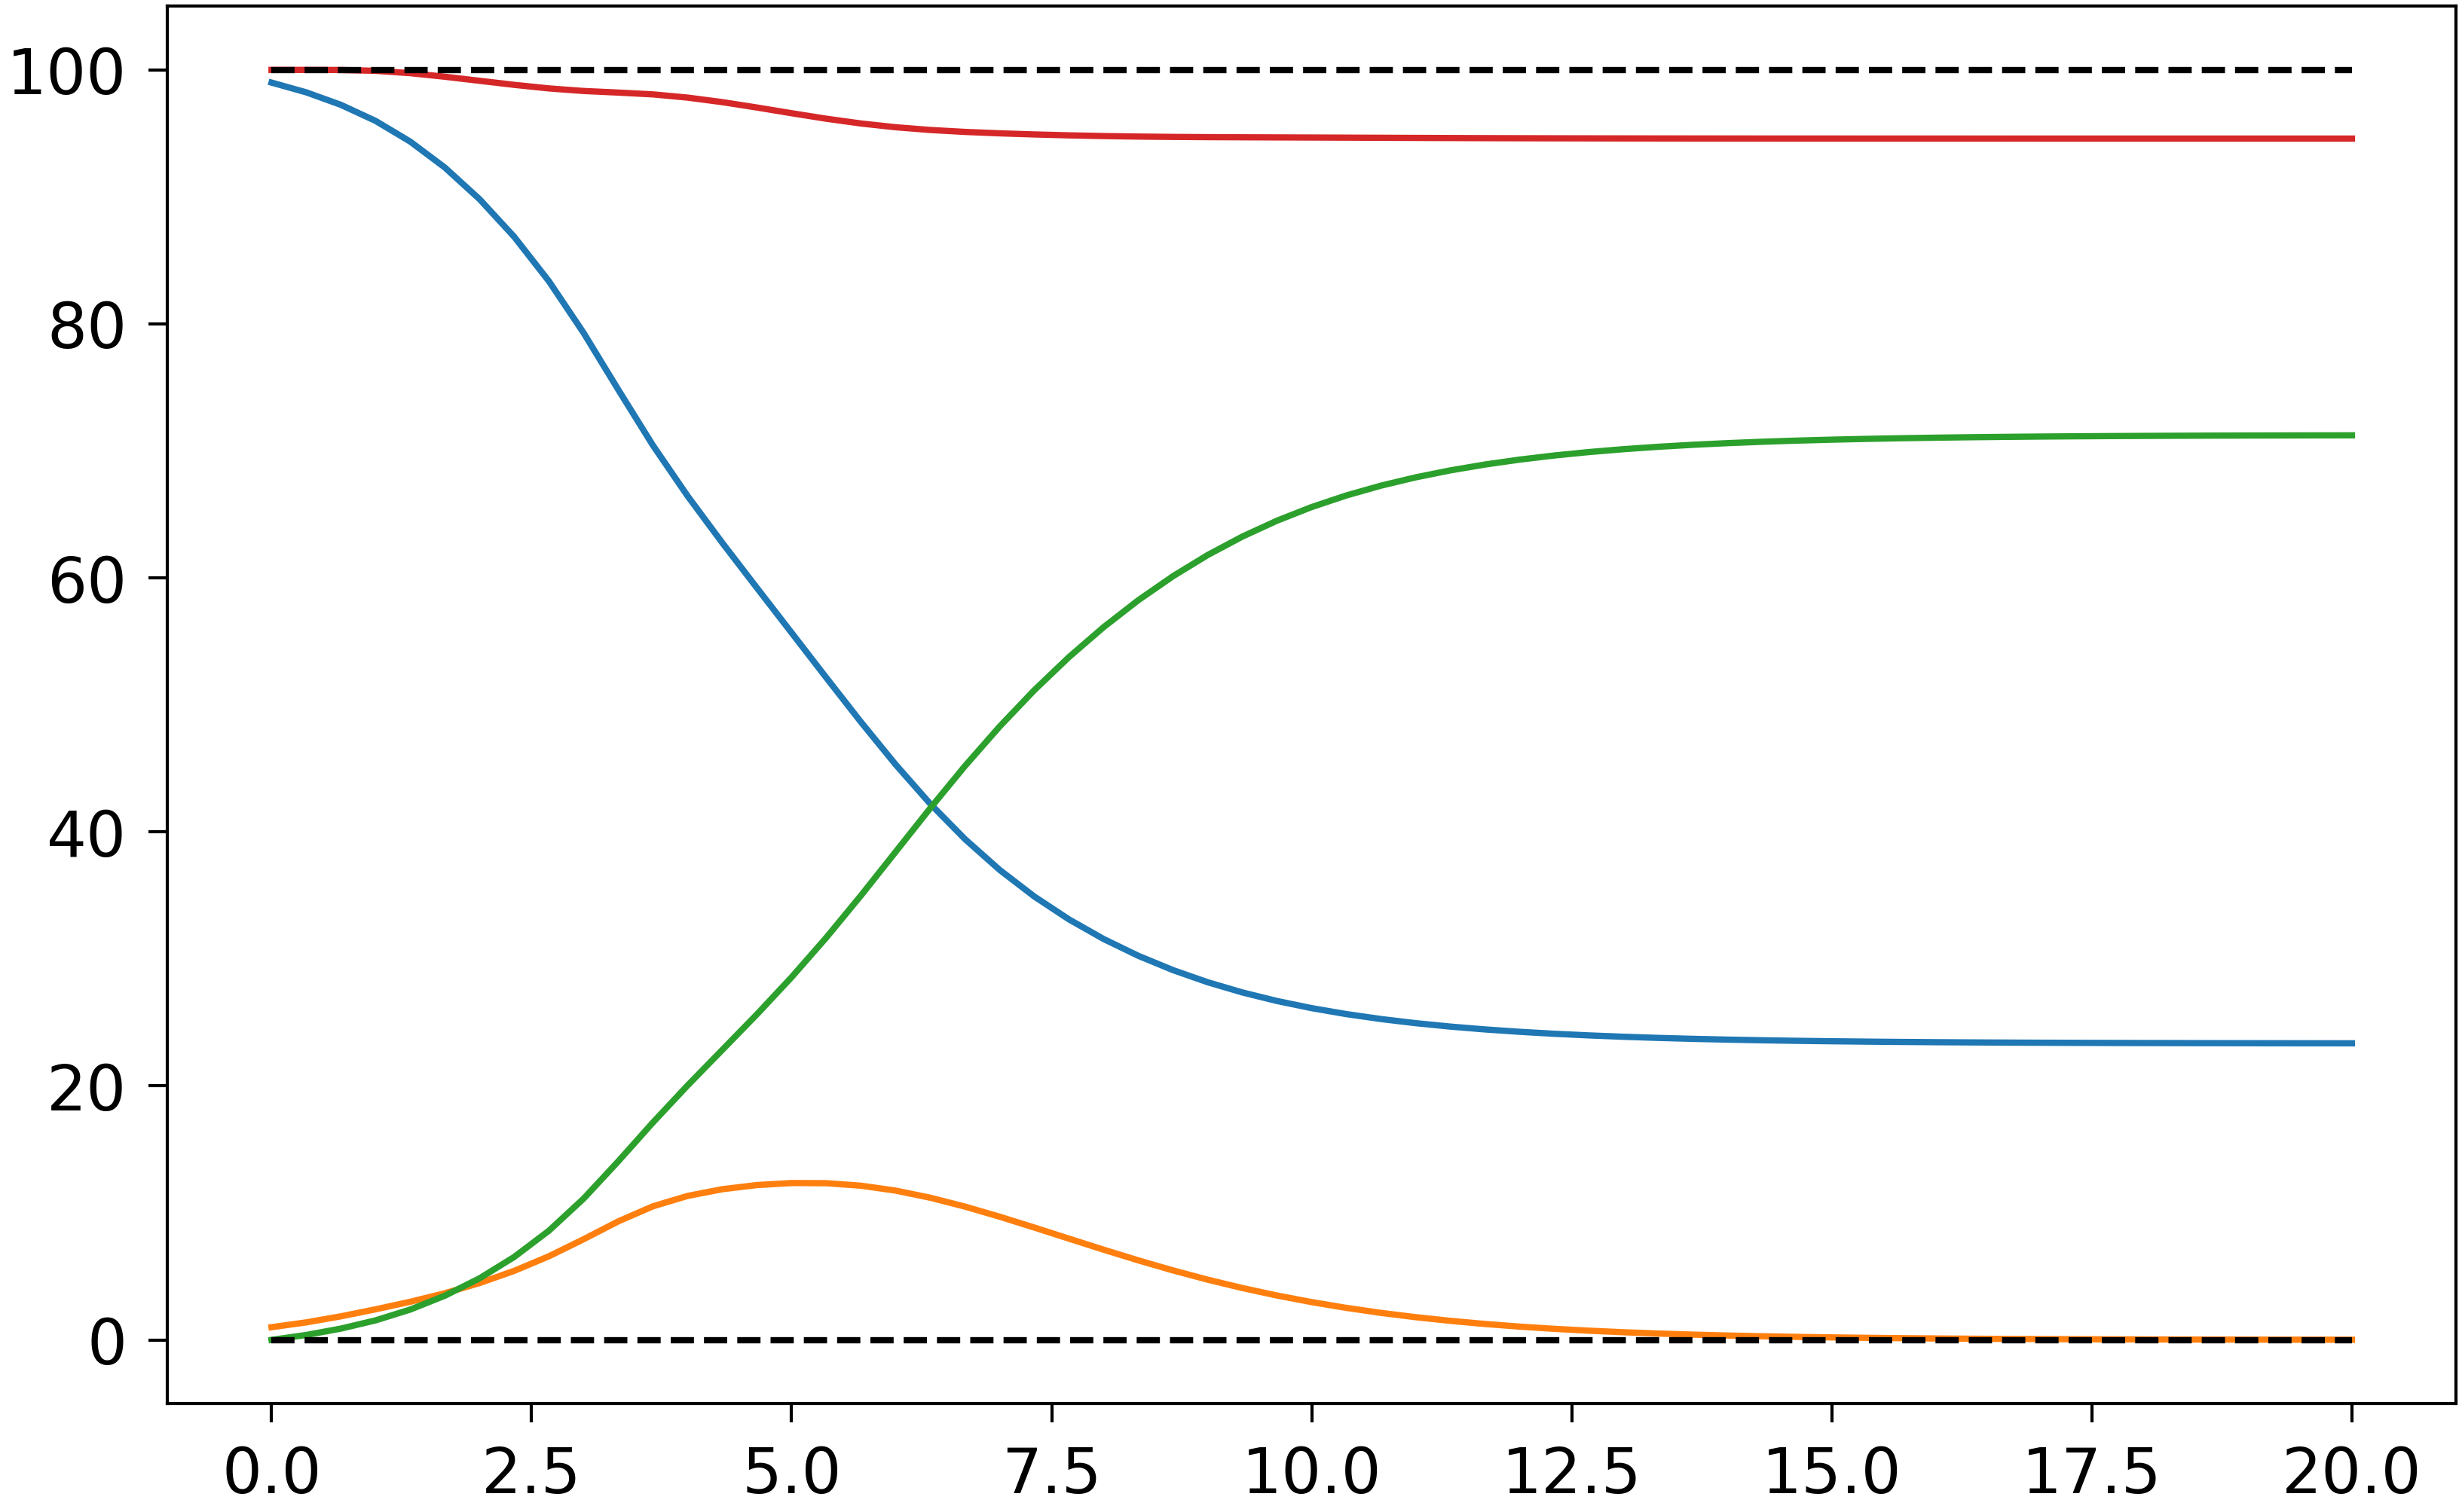

In [72]:
plt.figure()
plt.plot(ts, m_sequence[:,:3])
plt.plot(ts, m_sequence[:,0]+m_sequence[:,1]+m_sequence[:,2])
plt.plot(ts, np.zeros_like(ts), linestyle='--', color='black')
plt.plot(ts, 100*np.ones_like(ts), linestyle='--', color='black')
plt.show()

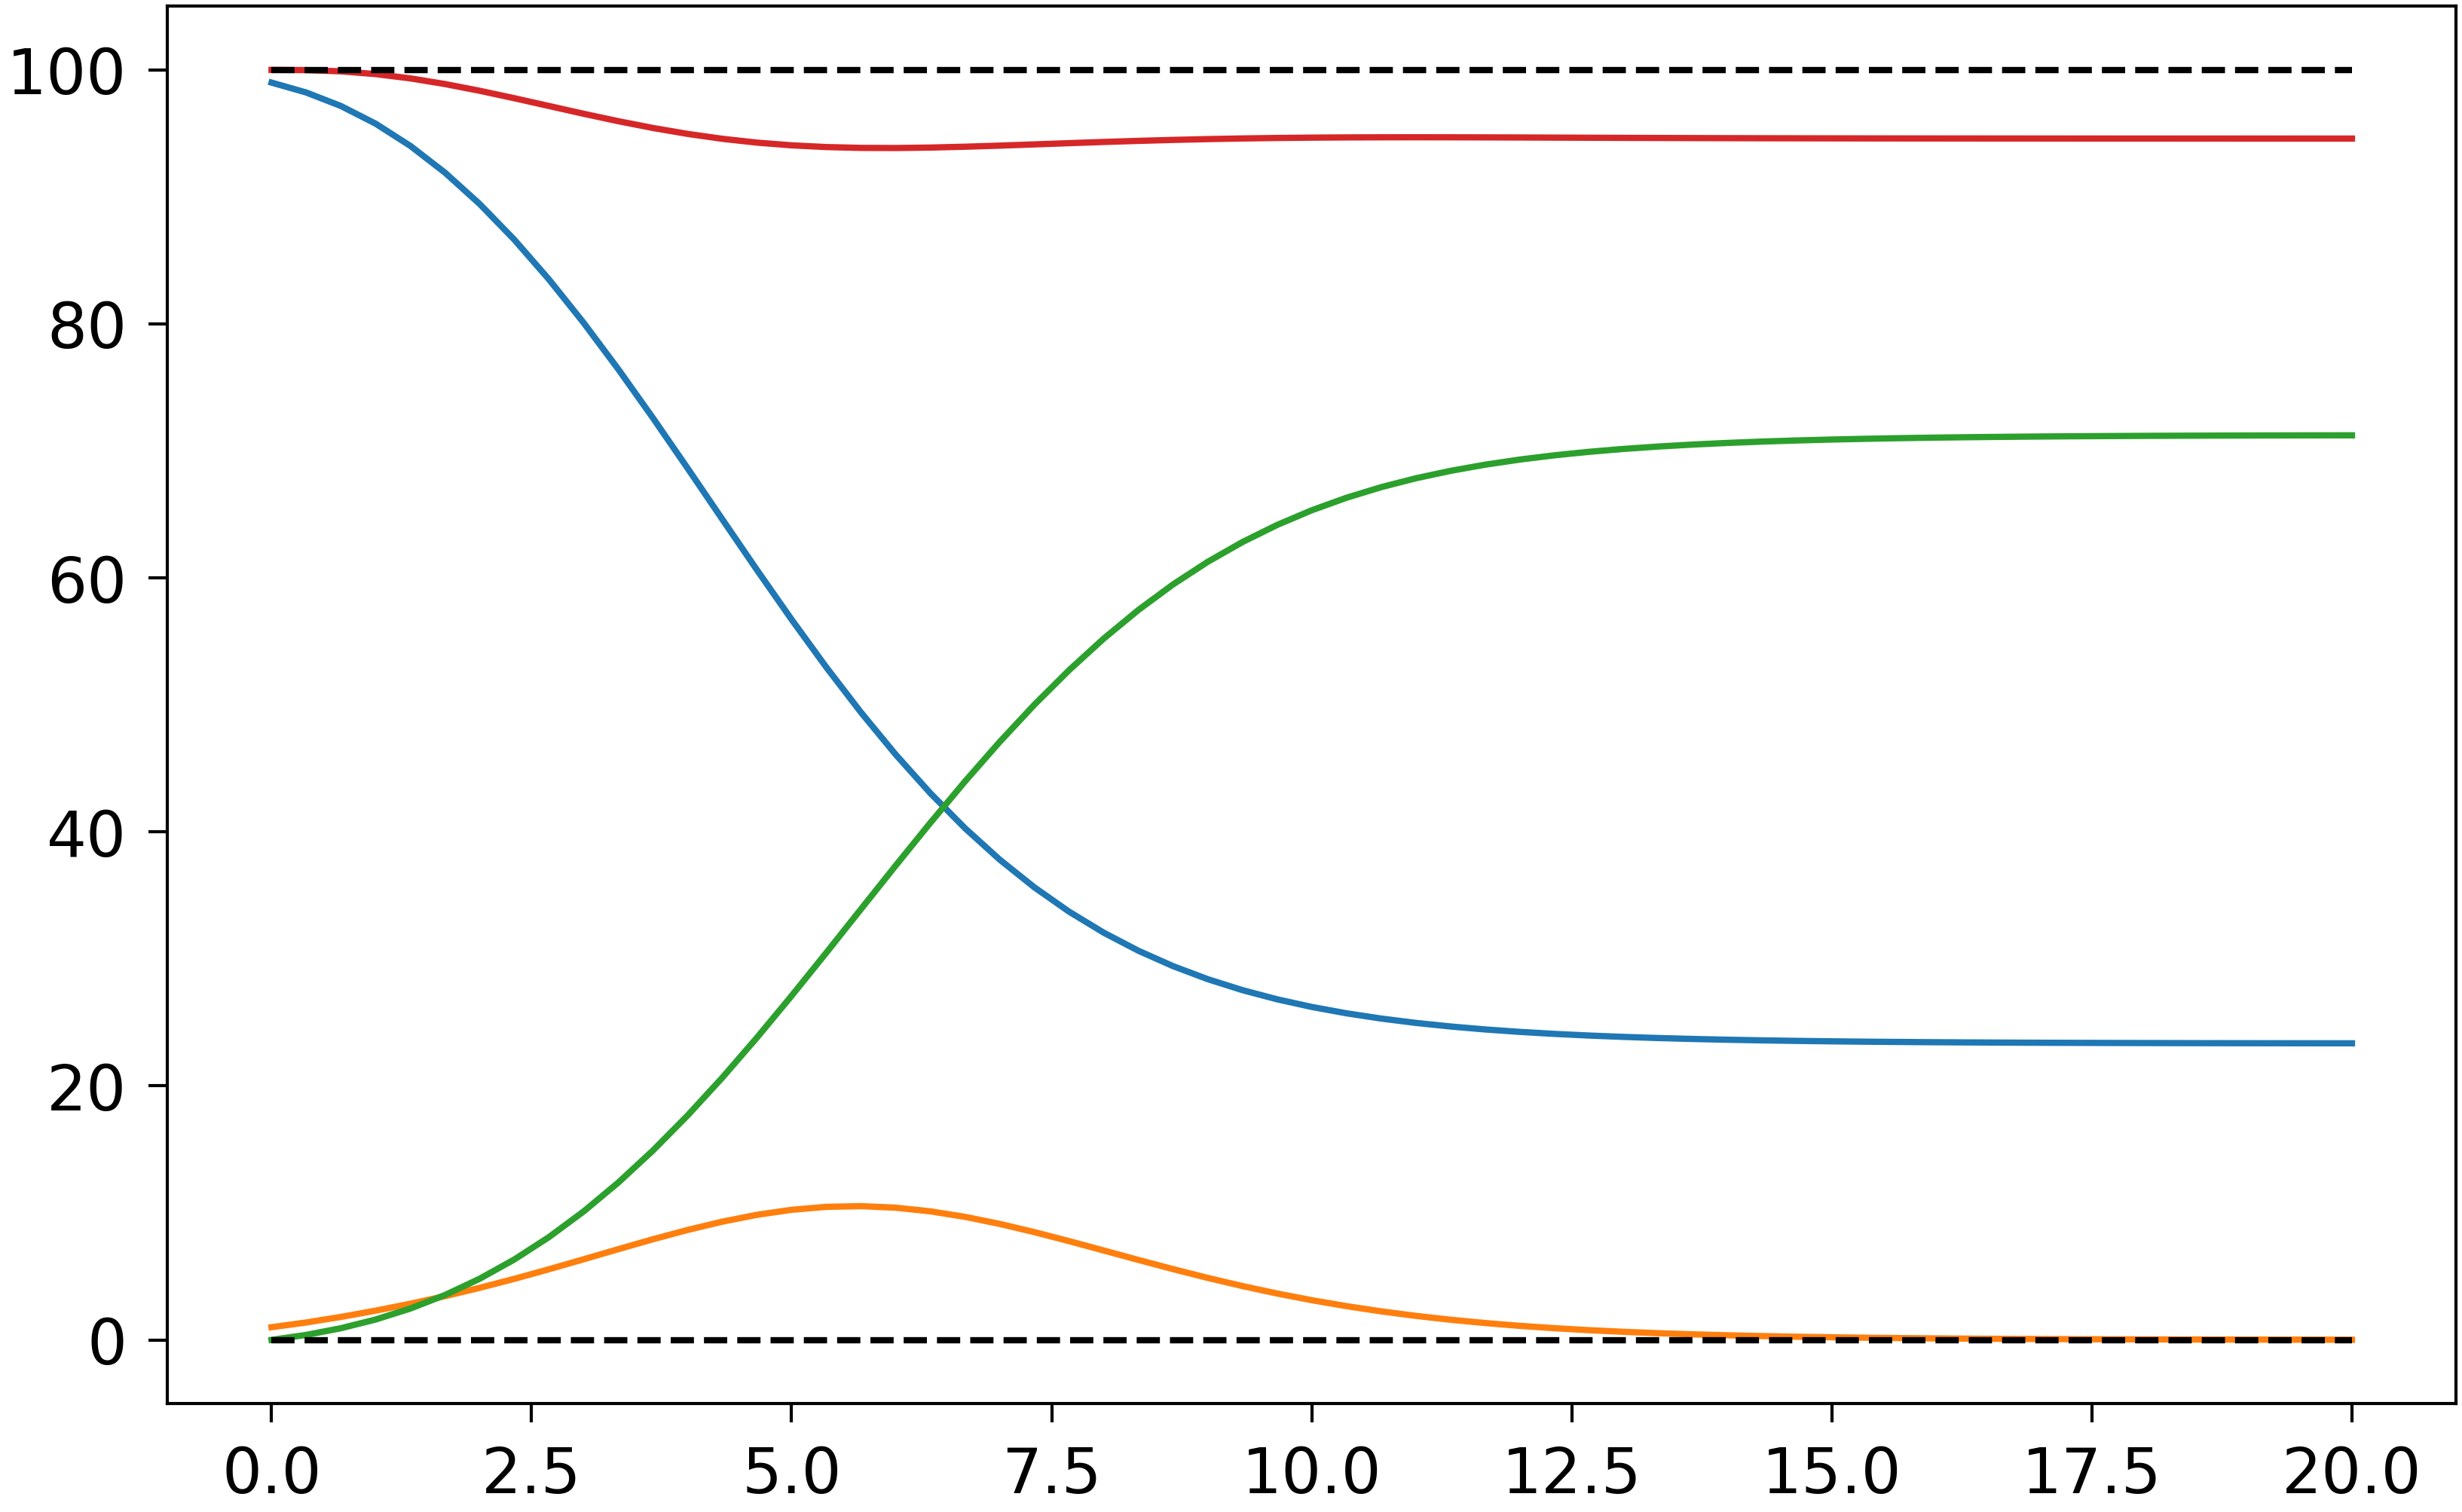

In [73]:
plt.figure()
plt.plot(ts, m_smoothed[:,:3])
plt.plot(ts, m_smoothed[:,0]+m_smoothed[:,1]+m_smoothed[:,2])
plt.plot(ts, np.zeros_like(ts), linestyle='--', color='black')
plt.plot(ts, 100*np.ones_like(ts), linestyle='--', color='black')
plt.show()

### Add conservation law
